In [303]:
import pandas as pd
import numpy as np

In [304]:
train_data = pd.read_csv("../../train.csv")
test_data = pd.read_csv("../../test.csv")

In [305]:
#Removing cols

#removing 'cabin' column because it has many NAN cols
cols = ['Ticket', 'Name', 'Cabin', 'Ticket', 'PassengerId']
train_data.drop(columns=cols, inplace=True)
test_data.drop(columns=cols, inplace=True)

In [306]:
train_data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [307]:
train_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [308]:
#fill NAN
def replace_numeric(columns: list, dataset: pd.DataFrame):
    nan_list = dataset.isnull().any()
    for col in columns:
        if nan_list[col]:
            temp = dataset[col]
            temp = temp.dropna()
            dataset[col].fillna(temp.mean(), inplace=True)

def replace_categorical(columns: list, dataset: pd.DataFrame):
    nan_list = dataset.isnull().any()
    for col in columns:
        if nan_list[col]:
            temp = dataset[col]
            temp = temp.dropna()
            dataset[col].fillna(value=temp.mode()[0], inplace=True)

numeric_cols = ['Age', 'Fare', 'Parch', 'SibSp']
replace_numeric(numeric_cols, train_data)
replace_numeric(numeric_cols, test_data)

categorical_cols = ['Embarked', 'Sex']
replace_categorical(categorical_cols, train_data)
replace_categorical(categorical_cols, test_data)

In [309]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [310]:
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [311]:
# mapping categorical to numeric
train_data = pd.concat([train_data, pd.get_dummies(train_data['Sex'], dtype=float)], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Sex'], dtype=float)], axis=1)

train_data = pd.concat([train_data, pd.get_dummies(train_data['Embarked'], dtype=float)], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Embarked'], dtype=float)], axis=1)

train_data['Fare'] = train_data['Fare'].map(lambda x: float(x))
test_data['Fare'] = test_data['Fare'].map(lambda x: float(x))

train_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)
test_data.drop(columns=['Sex', 'Embarked', 'Fare'], inplace=True)

In [312]:
train_data.dtypes

Survived      int64
Pclass        int64
Age         float64
SibSp         int64
Parch         int64
female      float64
male        float64
C           float64
Q           float64
S           float64
dtype: object

In [313]:
test_data.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
female    float64
male      float64
C         float64
Q         float64
S         float64
dtype: object

In [314]:
train_data

,Survived,Pclass,Age,SibSp,Parch,female,male,C,Q,S
0,0,3,22.000000,1,0,0.0,1.0,0.0,0.0,1.0
1,1,1,38.000000,1,0,1.0,0.0,1.0,0.0,0.0
2,1,3,26.000000,0,0,1.0,0.0,0.0,0.0,1.0
3,1,1,35.000000,1,0,1.0,0.0,0.0,0.0,1.0
4,0,3,35.000000,0,0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,0.0,1.0,0.0,0.0,1.0
887,1,1,19.000000,0,0,1.0,0.0,0.0,0.0,1.0
888,0,3,29.699118,1,2,1.0,0.0,0.0,0.0,1.0
889,1,1,26.000000,0,0,0.0,1.0,1.0,0.0,0.0


In [315]:
#spillitng data
x_train = train_data.drop(columns='Survived')
y_train = train_data['Survived']
x_test = test_data

In [316]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

Text(70.5, 0.5, 'Variable 1')

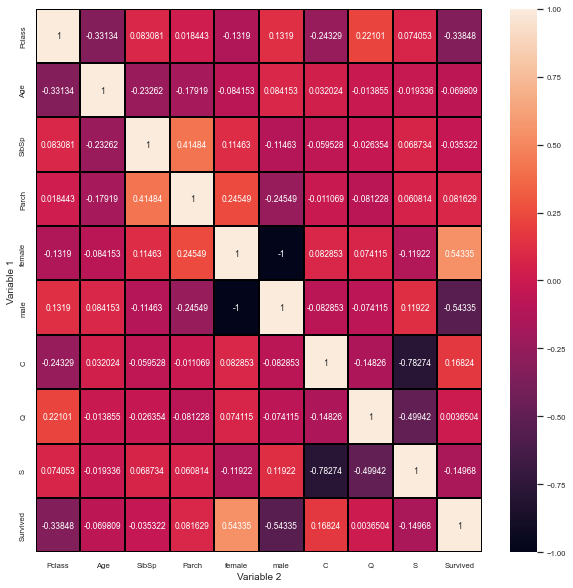

In [318]:
import seaborn as sns
import matplotlib.pyplot as plt

full_set = pd.concat([x_train, y_train], axis=1)
plt.figure(figsize=(len(full_set.columns), len(full_set.columns)), facecolor='w', edgecolor='k')
sns.set(font_scale=0.7)
sns.heatmap(full_set.corr(),
            annot=True,
            fmt='.5g',
            linewidths=2,
            linecolor='black')
plt.xlabel('Variable 2',fontsize=10)
plt.ylabel('Variable 1',fontsize=10)